In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

cat_dir = "/content/drive/MyDrive/PetImages/Cat"
dog_dir = "/content/drive/MyDrive/PetImages/Dog"

print("Number of Cat images:", len(os.listdir(cat_dir)))
print("Number of Dog images:", len(os.listdir(dog_dir)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of Cat images: 12499
Number of Dog images: 12499


In [ ]:
!curl -s https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh

#!/bin/sh

echo "PLEASE READ FOR 21.06"
echo "********************************************************************************************************"
echo "Another release, another script change.  We had to revise the script, which now:"
echo "1. Does a more comprehensive install"
echo "2. Includes BlazingSQL"
echo "3. is far easier for everyone to understand and maintain"
echo ""
echo "The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: "
echo "https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing"
echo ""
echo "CHANGES T"
echo "CELL 1:"
echo "    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only."
echo "    # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps."
echo "    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git"
echo "    !python rapidsai-csp-util

In [ ]:
# Imports
import os, cv2, time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

from cuml.svm import SVC as cuSVC   # GPU SVM
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Dataset Path
data_dir = "/content/drive/MyDrive/PetImages"
categories = ["Cat", "Dog"]

In [ ]:
X, y = [], []
img_size = 128
limit = 2000   # number of images per class (increase for better accuracy)

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    print(f"Loading {category} images...")

    for img_name in os.listdir(path)[:limit]:
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # HOG features
            features, _ = hog(
                gray, orientations=9, pixels_per_cell=(8,8),
                cells_per_block=(2,2), block_norm="L2-Hys", visualize=True
            )
            X.append(features)
            y.append(label)
        except:
            continue

X = np.array(X)
y = np.array(y)

print("Dataset loaded---")
print("Feature shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique labels:", np.unique(y))

Loading Cat images...
Loading Dog images...
Dataset loaded---
Feature shape: (4000, 8100)
Labels shape: (4000,)
Unique labels: [0 1]


In [ ]:
#  Train-Test Split + Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Manual Hyperparameter Search
params = {
    "C": [1, 10, 50],
    "gamma": ["scale", 0.01, 0.001],
    "kernel": ["linear", "rbf"]
}

best_acc = 0
best_params = None
results = []

print(" Running hyperparameter tuning on GPU...")

for C in params["C"]:
    for gamma in params["gamma"]:
        for kernel in params["kernel"]:
            print(f"Testing: C={C}, gamma={gamma}, kernel={kernel}")
            start = time.time()

            model = cuSVC(C=C, gamma=gamma, kernel=kernel)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            duration = round(time.time() - start, 2)
            results.append((C, gamma, kernel, acc, duration))
            print(f"  -> Accuracy: {acc:.4f}, Time: {duration}s")

            if acc > best_acc:
                best_acc = acc
                best_params = (C, gamma, kernel)

print("\n Best Params:", best_params)
print("Best Accuracy:", best_acc)

 Running hyperparameter tuning on GPU...
Testing: C=1, gamma=scale, kernel=linear
  -> Accuracy: 0.6900, Time: 11.9s
Testing: C=1, gamma=scale, kernel=rbf
  -> Accuracy: 0.7650, Time: 2.25s
Testing: C=1, gamma=0.01, kernel=linear
  -> Accuracy: 0.6900, Time: 11.93s
Testing: C=1, gamma=0.01, kernel=rbf
  -> Accuracy: 0.4988, Time: 1.57s
Testing: C=1, gamma=0.001, kernel=linear
  -> Accuracy: 0.6900, Time: 11.93s
Testing: C=1, gamma=0.001, kernel=rbf
  -> Accuracy: 0.5775, Time: 2.25s
Testing: C=10, gamma=scale, kernel=linear
  -> Accuracy: 0.6900, Time: 11.24s
Testing: C=10, gamma=scale, kernel=rbf
  -> Accuracy: 0.7700, Time: 3.09s
Testing: C=10, gamma=0.01, kernel=linear
  -> Accuracy: 0.6900, Time: 11.98s
Testing: C=10, gamma=0.01, kernel=rbf
  -> Accuracy: 0.4988, Time: 1.61s
Testing: C=10, gamma=0.001, kernel=linear
  -> Accuracy: 0.6900, Time: 11.83s
Testing: C=10, gamma=0.001, kernel=rbf
  -> Accuracy: 0.5750, Time: 2.48s
Testing: C=50, gamma=scale, kernel=linear
  -> Accuracy: 0

In [ ]:
# Train SVM
print("Training SVM ...")
start = time.time()

model = cuSVC(kernel="rbf", C=10, gamma="scale")  # cuML SVM
model.fit(X_train, y_train)

end = time.time()
print(" Training complete in", round(end-start,2), "sec")

Training SVM ...
 Training complete in 2.93 sec


In [ ]:
# Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"SVM Accuracy: {acc:.4f}")


SVM Accuracy: 0.7700


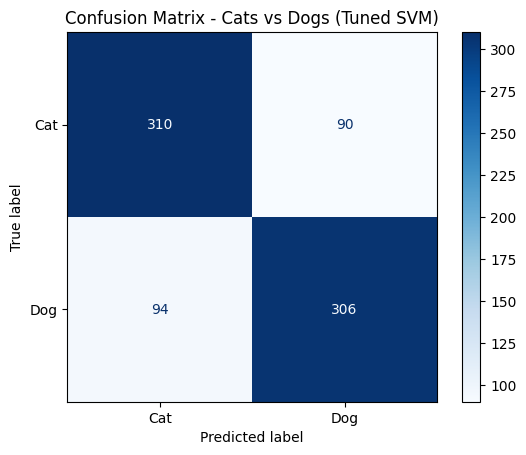

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Cats vs Dogs (Tuned SVM)")
plt.show()

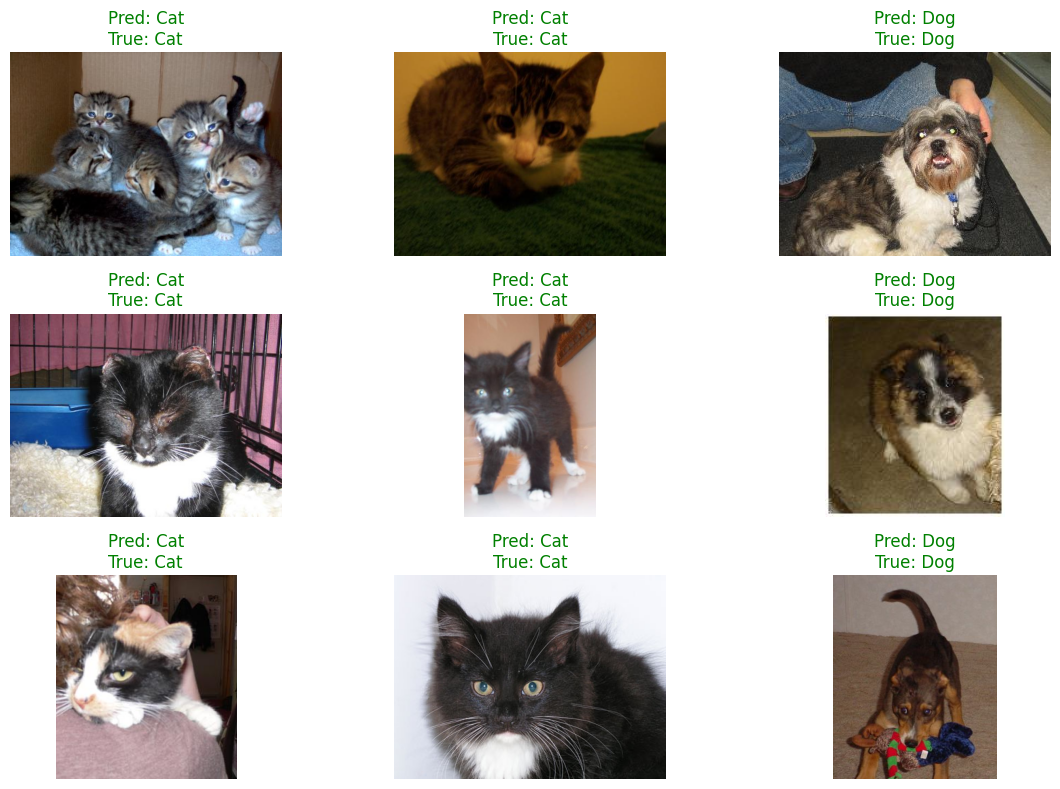

In [ ]:
# Sample Predictions
import random

plt.figure(figsize=(12,8))
indices = random.sample(range(len(X_test)), 9)

for i, idx in enumerate(indices):
    # Pick an image from test set
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Reload original image for display
    folder = categories[true_label]
    folder_path = os.path.join(data_dir, folder)
    img_name = os.listdir(folder_path)[idx % len(os.listdir(folder_path))]
    img_path = os.path.join(folder_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {categories[pred_label]}\nTrue: {categories[true_label]}", color=color)

plt.tight_layout()
plt.show()